In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('kings_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,93202,Kings County,1,2015,Residential,588051.0,0.588051
1,93202,Kings County,1,2015,Commercial,139871.0,0.139871
2,93212,Kings County,1,2015,Agricultural,1715714.0,1.715714
3,93230,Kings County,1,2015,Residential,12618684.0,12.618684
4,93230,Kings County,1,2015,Commercial,8272566.0,8.272566


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        587 non-null    int64  
 1   County         587 non-null    object 
 2   Month          587 non-null    int64  
 3   Year           587 non-null    int64  
 4   CustomerClass  587 non-null    object 
 5   TotalkWh       587 non-null    float64
 6   TotalGWh       587 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 32.2+ KB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        587 non-null    int64         
 1   County         587 non-null    object        
 2   Month          587 non-null    int64         
 3   Year           587 non-null    int64         
 4   CustomerClass  587 non-null    object        
 5   TotalkWh       587 non-null    float64       
 6   TotalGWh       587 non-null    float64       
 7   Date           587 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 36.8+ KB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,93202,Kings County,1,2015,Residential,588051.0,0.588051
2015-01-01,93202,Kings County,1,2015,Commercial,139871.0,0.139871
2015-01-01,93212,Kings County,1,2015,Agricultural,1715714.0,1.715714
2015-01-01,93230,Kings County,1,2015,Residential,12618684.0,12.618684
2015-01-01,93230,Kings County,1,2015,Commercial,8272566.0,8.272566


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,27477871.0,27.477871
2015-02-28,28010833.0,28.010833
2015-03-31,27059538.0,27.059538
2015-04-30,31276628.0,31.276628
2015-05-31,32048165.0,32.048165


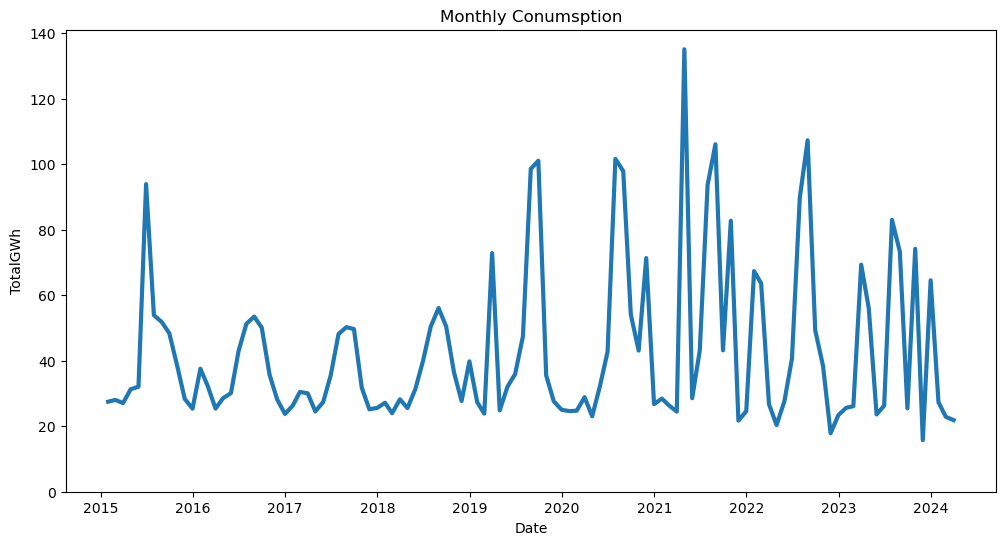

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -1.0895236153149412
p-value: 0.7192316325628789
Non-Stationary


***SARIMAX model can still handle non-stationary data***

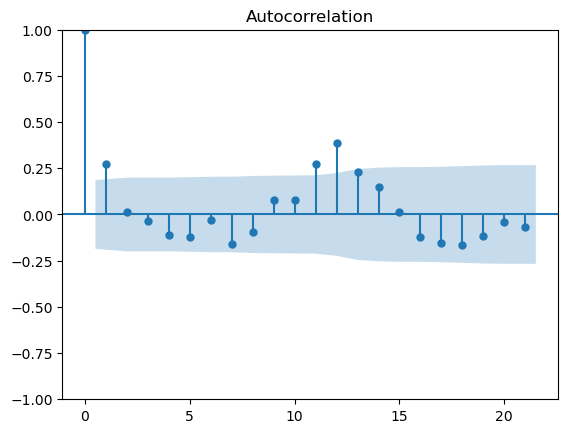

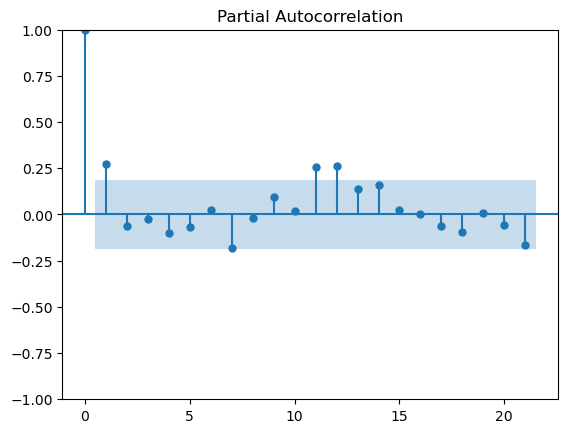

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1057.040, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1041.761, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1055.040, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1046.892, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1037.443, Time=0.26 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1038.572, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1037.791, Time=0.17 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1054.953, Time=0.15 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1025.859, Time=0.38 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1033.486, Time=0.17 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=1025.612, Time=1.04 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1026.015, Time=0.53 sec
 ARIMA(2,1,0)(2,0,2)[12] inte

C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(5,1,0)(2,0,2)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\adamc\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = s

 ARIMA(5,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(5,1,1)(1,0,1)[12] intercept   : AIC=1006.164, Time=1.68 sec
 ARIMA(5,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(5,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(5,1,1)(2,0,1)[12] intercept   : AIC=1006.752, Time=2.54 sec
 ARIMA(5,1,1)(1,0,2)[12] intercept   : AIC=1007.318, Time=1.94 sec
 ARIMA(5,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(5,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(5,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(5,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.74 sec
 ARIMA(4,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(5,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(4,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(5,1,1)(1,0,1)[12]             : AIC=1002.496, Time=0.61 sec
 ARIMA(5,1,1)(0,0,1)[12]             : AIC=1013.429, Time=0.46 sec
 ARIMA(5,1,1)(1,0,0)[12]             : AIC=100

C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,1,1)(2,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\adamc\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = s

 ARIMA(4,1,1)(2,0,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(3,1,1)(1,0,1)[12]             : AIC=999.812, Time=0.53 sec
 ARIMA(3,1,1)(0,0,1)[12]             : AIC=1010.339, Time=0.38 sec
 ARIMA(3,1,1)(1,0,0)[12]             : AIC=1005.299, Time=0.34 sec
 ARIMA(3,1,1)(2,0,1)[12]             : AIC=1001.967, Time=1.27 sec
 ARIMA(3,1,1)(1,0,2)[12]             : AIC=1001.697, Time=1.06 sec
 ARIMA(3,1,1)(0,0,0)[12]             : AIC=1017.382, Time=0.16 sec
 ARIMA(3,1,1)(0,0,2)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(3,1,1)(2,0,0)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(3,1,1)(2,0,2)[12]             : AIC=inf, Time=2.10 sec
 ARIMA(2,1,1)(1,0,1)[12]             : AIC=997.858, Time=0.42 sec
 ARIMA(2,1,1)(0,0,1)[12]             : AIC=1008.600, Time=0.29 sec
 ARIMA(2,1,1)(1,0,0)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(2,0,1)[12]             : AIC=999.711, Time=1.27 sec
 ARIMA(2,1,1)(1,0,2)[12]             : AIC=999.729, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[12] 

C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,1)(2,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\adamc\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\adamc\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = s

 ARIMA(1,1,1)(2,0,2)[12]             : AIC=inf, Time=nan sec

Best model:  ARIMA(1,1,1)(1,0,1)[12]          
Total fit time: 73.921 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  111
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -493.256
Date:                            Mon, 22 Apr 2024   AIC                            996.512
Time:                                    21:51:46   BIC                           1010.014
Sample:                                01-31-2015   HQIC                          1001.988
                                     - 03-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

In [18]:
# p, d, q parameters
model.order

(1, 1, 1)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(1, 0, 1, 12)

In [20]:
# Define SARIMA parameters from AutoArima results

# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

### Forecasting the next 12 months

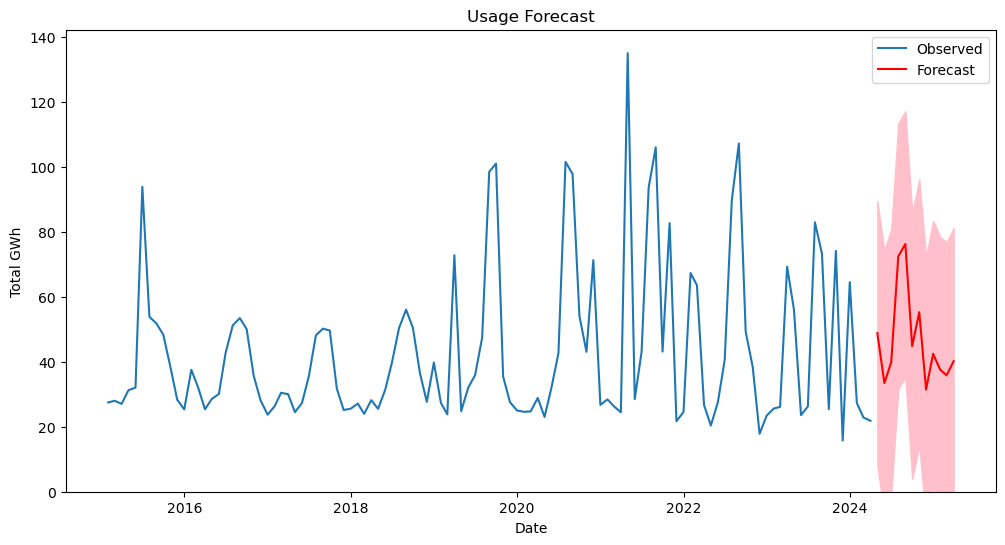

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

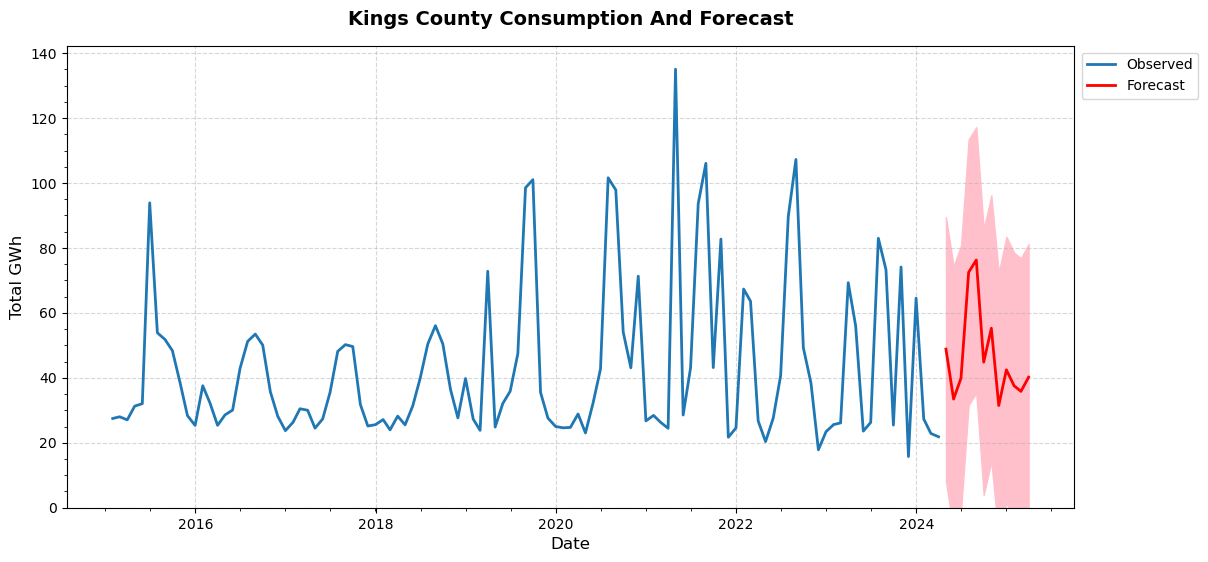

In [22]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(13, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Kings County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.13,1), loc='upper right')

# Show plot
#plt.savefig('kings_c.png')
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 13.4772085094717
MSE: 210.69216174692943
RMSE: 14.515238949012497


In [24]:
observed

Date
2023-04-30    56.041117
2023-05-31    23.588529
2023-06-30    26.258823
2023-07-31    82.971173
2023-08-31    73.294641
2023-09-30    25.443634
2023-10-31    74.138324
2023-11-30    15.763431
2023-12-31    64.530898
2024-01-31    27.328543
2024-02-29    22.862823
2024-03-31    21.843961
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2024-04-30    48.853298
2024-05-31    33.454831
2024-06-30    39.901217
2024-07-31    72.502660
2024-08-31    76.280019
2024-09-30    44.829394
2024-10-31    55.278524
2024-11-30    31.462199
2024-12-31    42.469933
2025-01-31    37.573139
2025-02-28    35.840268
2025-03-31    40.192722
Freq: M, Name: predicted_mean, dtype: float64

### Forecasting the next 24 months

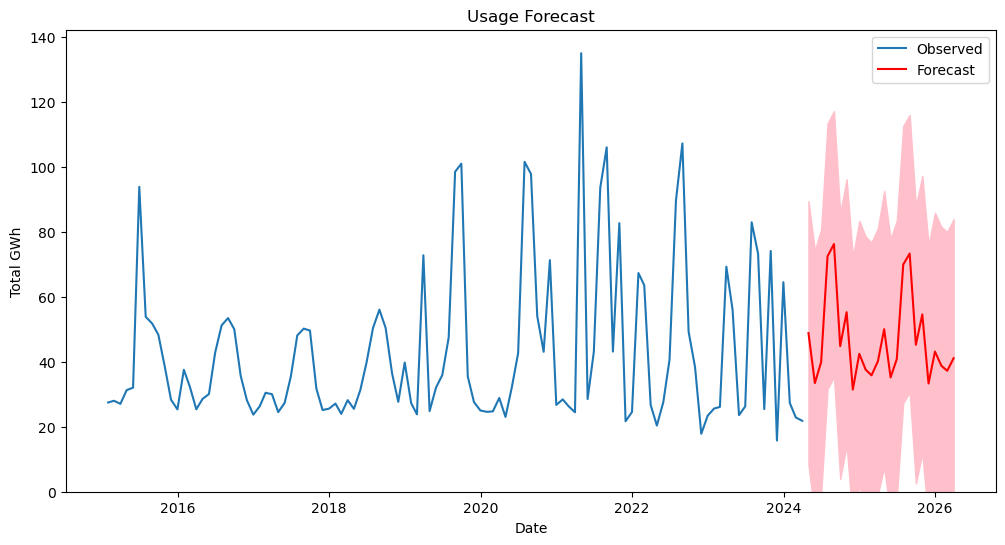

In [26]:
# Forecast future demand
forecast_periods = 24  # Forecast the next 24 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

### Evaluate Model

In [27]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 14.867285186449095
MSE: 285.19953853712536
RMSE: 16.887851803504358


In [28]:
observed

Date
2022-04-30     20.366675
2022-05-31     27.588886
2022-06-30     40.669243
2022-07-31     89.715327
2022-08-31    107.255540
2022-09-30     49.285074
2022-10-31     38.377676
2022-11-30     17.839068
2022-12-31     23.419044
2023-01-31     25.617072
2023-02-28     26.117265
2023-03-31     69.308697
2023-04-30     56.041117
2023-05-31     23.588529
2023-06-30     26.258823
2023-07-31     82.971173
2023-08-31     73.294641
2023-09-30     25.443634
2023-10-31     74.138324
2023-11-30     15.763431
2023-12-31     64.530898
2024-01-31     27.328543
2024-02-29     22.862823
2024-03-31     21.843961
Freq: M, Name: TotalGWh, dtype: float64

In [29]:
forecast_mean

2024-04-30    48.853298
2024-05-31    33.454831
2024-06-30    39.901217
2024-07-31    72.502660
2024-08-31    76.280019
2024-09-30    44.829394
2024-10-31    55.278524
2024-11-30    31.462199
2024-12-31    42.469933
2025-01-31    37.573139
2025-02-28    35.840268
2025-03-31    40.192722
2025-04-30    50.047824
2025-05-31    35.200201
2025-06-30    40.869399
2025-07-31    69.964679
2025-08-31    73.336052
2025-09-30    45.261428
2025-10-31    54.588902
2025-11-30    33.329120
2025-12-31    43.155238
2026-01-31    38.784087
2026-02-28    37.237228
2026-03-31    41.122473
Freq: M, Name: predicted_mean, dtype: float64

In [30]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Agricultural    1058.458418
Commercial      1006.830020
Industrial      1008.177763
Residential     1681.001733
Name: TotalGWh, dtype: float64

In [31]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Agricultural,1058.458418
1,Commercial,1006.830020
2,Industrial,1008.177763
3,Residential,1681.001733


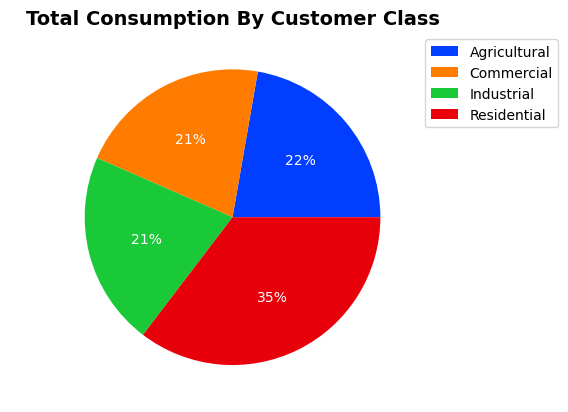

In [32]:

# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='w'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

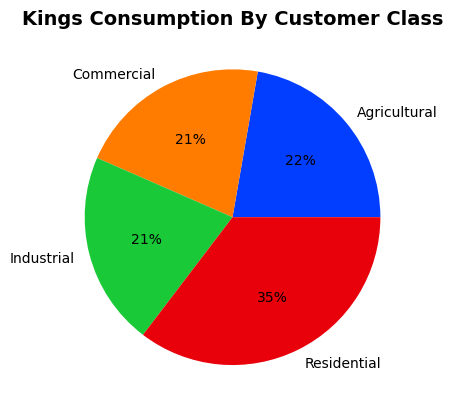

In [33]:
# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'],labels=customer_df['CustomerClass'],colors=palette_color, autopct='%.0f%%', textprops=dict(color='black'))
plt.title('Kings Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
#plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()